<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/LRNewUpdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    file_counter = 0

    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Process 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        df_2000KHz_grouped = df_2000KHz.groupby(df_2000KHz.index // 10000).mean().reset_index(drop=True)
        df_2000KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_2000KHz_grouped.index, unit='ms')
        df_2000KHz_grouped['label'] = label

        # Process 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        df_100KHz_grouped = df_100KHz.groupby(df_100KHz.index // 10000).mean().reset_index(drop=True)
        df_100KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_100KHz_grouped.index, unit='ms')
        df_100KHz_grouped['label'] = label

        combined_100KHzdata.append(df_100KHz_grouped)
        combined_2000KHzdata.append(df_2000KHz_grouped)

        file_counter += 1

    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

def preprocess_data(ok_data_path, nok_data_path):
    ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
    nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

    all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
    all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

    return all_100KHzdata, all_2000KHzdata

def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    # Merge on timestamp
    combined_data = pd.merge_asof(data_100KHz.sort_values('timestamp'),
                                  data_2000KHz.sort_values('timestamp'),
                                  on='timestamp',
                                  by='label',
                                  direction='nearest')

    # Interpolate to fill missing values
    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data
def normalize_data(combined_data):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data


In [3]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Calculate accuracy precision, recall, and F1 score
    accuracy = accuracy_score (y, y_pred_classes)
    precision = precision_score(y, y_pred_classes)
    recall = recall_score(y, y_pred_classes)
    f1 = f1_score(y, y_pred_classes)

    # Print the classification report
    print(classification_report(y, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracy, precision, recall, f1

In [4]:
import pandas as pd
from sklearn.utils import shuffle

# Define paths to data
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Preprocess data
all_100KHzdata, all_2000KHzdata = preprocess_data(ok_data_path, nok_data_path)

# Combine and interpolate data
combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)

# Normalize data
normalized_data = normalize_data(combined_data)

# Shuffle the combined data
normalized_data = shuffle(normalized_data, random_state=42)

# normalized_data.head()

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4615
           1       0.80      0.76      0.78      3908

    accuracy                           0.81      8523
   macro avg       0.80      0.80      0.80      8523
weighted avg       0.81      0.81      0.80      8523



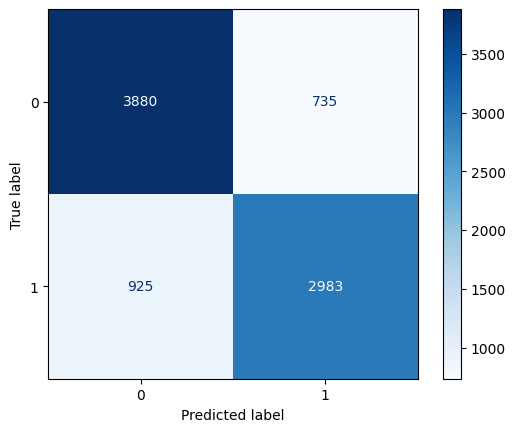

Training Accuracy: 80.52%, Training Precision: 0.80, Training Recall: 0.76, Training F1 Score: 0.78
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1992
           1       0.82      0.79      0.80      1662

    accuracy                           0.82      3654
   macro avg       0.82      0.82      0.82      3654
weighted avg       0.82      0.82      0.82      3654



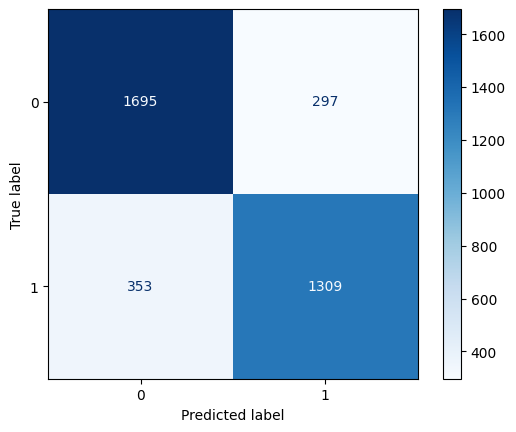

Test Accuracy: 82.21%, Test Precision: 0.82, Test Recall: 0.79, Test F1 Score: 0.80

Results Summary:
    Dataset  Accuracy  Precision    Recall  F1 Score
0  Training  0.805233   0.802313  0.763306  0.782324
1      Test  0.822113   0.815068  0.787605  0.801102


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# split the data into train and test data
X=normalized_data.iloc[:,1:-1]
y=normalized_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

#train the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluate the model on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(log_reg, X_train, y_train)
print(f"Training Accuracy: {train_accuracy*100:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}")

# Evaluate the model on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(log_reg, X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}")

# Create a results table
results = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [train_accuracy, test_accuracy],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1 Score": [train_f1, test_f1]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)